In [3]:
import pandas as pd
import geopandas as gpd
from SPARQLWrapper import SPARQLWrapper, JSON

In [4]:
# Define the SPARQL endpoint URL
sparql_url = "https://query.wikidata.org/sparql"

# Create a SPARQLWrapper object with the defined URL
sparql = SPARQLWrapper(sparql_url)

# Define your SPARQL query
sparql_query = """
SELECT DISTINCT ?item ?itemLabel ?bmrs_id ?repd_id ?lat ?lon ?capacity ?typeLabel WHERE {
  ?item wdt:P11610 ?bmrs_id.
  OPTIONAL { ?item wdt:P9891 ?repd_id. }
  OPTIONAL { ?item wdt:P2109 ?capacity. }
  OPTIONAL {
    ?item p:P625 ?point .
    ?point psv:P625 ?point_value .
    ?point_value wikibase:geoLatitude ?lat.
    ?point_value wikibase:geoLongitude ?lon.
  }
  OPTIONAL {
    ?item wdt:P31 ?type.
    ?type wdt:P279+ wd:Q159719.
  }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
"""

# Set the query to the SPARQLWrapper object
sparql.setQuery(sparql_query)

# Set the return format to JSON (SPARQLWrapper supports XML, JSON, and others)
sparql.setReturnFormat(JSON)

# Execute the query and convert the result to a Python dictionary
results = sparql.query().convert()

In [5]:
lats = [float(result.get("lat", {"value": "0"})["value"]) for result in results["results"]["bindings"]]
lons = [float(result.get("lon", {"value": "0"})["value"]) for result in results["results"]["bindings"]]
bmids = [result.get("bmrs_id", {"value": "0"})["value"] for result in results["results"]["bindings"]]
repdid = [result.get("repd_id", {"value": "0"})["value"] for result in results["results"]["bindings"]]
cap = [float(result.get("capacity", {"value": "0"})["value"]) for result in results["results"]["bindings"]]
item = [result.get("item", {"value": "0"})["value"] for result in results["results"]["bindings"]]
itemlabel = [result.get("itemLabel", {"value": "0"})["value"] for result in results["results"]["bindings"]]
typelabel = [result.get("typeLabel", {"value": "0"})["value"] for result in results["results"]["bindings"]]

wiki = pd.DataFrame({
    "lat": lats,
    "lon": lons,
    "bmrs_id": bmids,
    "repd_id": repdid,
    "capacity": cap,
    "item": item,
    "itemlabel": itemlabel,
    "type": typelabel
    })

In [27]:
bm = pd.read_csv("last_week_bm.csv", index_col=[0,1,2])

print(bm.columns)
bm.loc[:, ["change"]] = bm["LevelTo"].sub(bm["LevelFrom"], axis=0)
bm.loc[:, ["abs_change"]] = bm["change"].abs()

Index(['LevelFrom', 'LevelTo', 'BmUnit'], dtype='object')


In [28]:
bm.groupby(level=2)["abs_change"].mean().sort_values(ascending=False).head(10)

NationalGridBmUnit
LON-LON01    39.091146
SPLN-1       23.807292
ROCK-1       16.872396
DINO-4       16.393229
DINO-6       14.177083
DINO-2       10.479167
HOWBO-3      10.273438
HOWBO-1      10.273438
EAS-LON01     9.565104
SSC-LON01     9.497396
Name: abs_change, dtype: float64

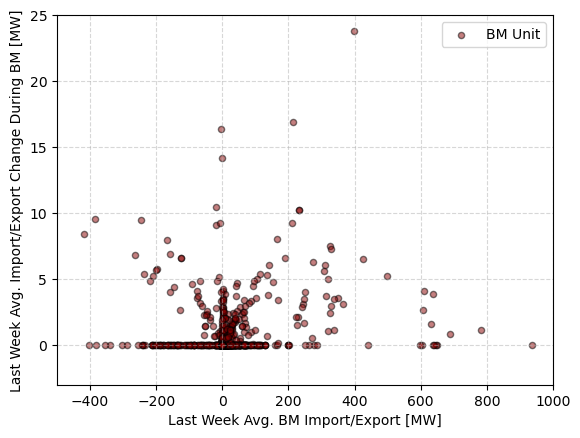

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(
    bm.groupby(level=2)["LevelTo"].mean(),
    bm.groupby(level=2)["abs_change"].mean(),
    s=20,
    c="darkred",
    alpha=0.5,
    edgecolors="k",
    label="BM Unit",
)
ax.legend()

ax.grid(True, linestyle='--', alpha=0.5)

ax.set_xlabel("Last Week Avg. BM Import/Export [MW]")
ax.set_ylabel("Last Week Avg. Import/Export Change During BM [MW]")

# ax.set_xlim(-500, 1000)
# ax.set_ylim(-3, 25)

plt.show()

In [ ]:
idx = pd.IndexSlice

fig, axs = plt.subplots(3, 1, figsize=(15, 12))
n = 5

for ax, metric, fac in zip(axs, ["LevelTo", "LevelTo", "abs_change"], [1, -1, 1]):
    ax.set_title(metric, fac)

    bms = (
        bm.groupby(level=2)["abs_change"].mean()
        .mul(fac)
        .sort_values(ascending=False)
        .head(5)
        .index
    )
    for unit in bms:
        bm.loc[idx]

    ax.grid(True, linestyle='--', alpha=0.5)

plt.show()

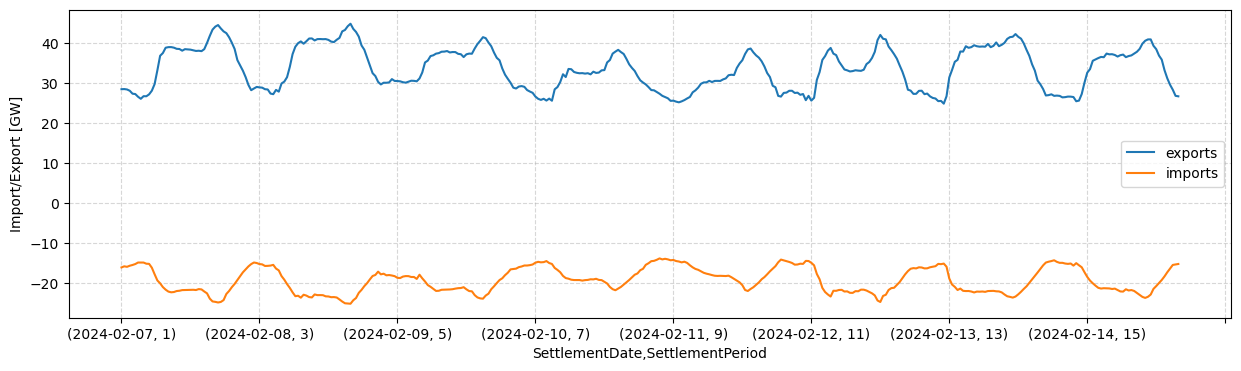

In [49]:
pos = bm.loc[bm["LevelTo"] >= 0, "LevelTo"]
neg = bm.loc[bm["LevelTo"] < 0, "LevelTo"]

fig, ax = plt.subplots(figsize=(15, 4))

pos.groupby(level=[0,1]).sum().mul(1e-3).plot(label="exports", ax=ax)
neg.groupby(level=[0,1]).sum().mul(1e-3).plot(label="imports", ax=ax)

ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_ylabel("Import/Export [GW]")
plt.show()


#### Wiki

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

idx = pd.IndexSlice

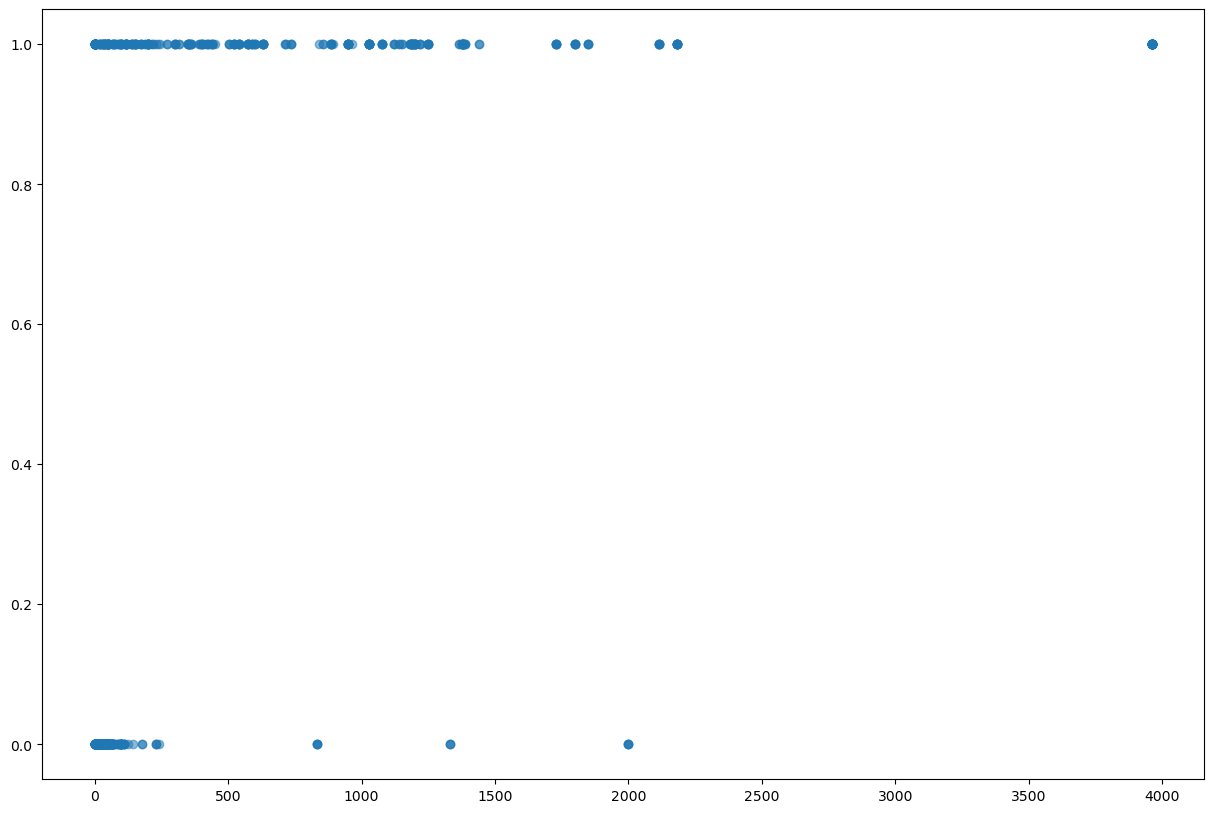

In [53]:
sorted_wiki = wiki.sort_values(by="capacity", ascending=True)

fig, ax = plt.subplots(figsize=(15, 10))


ax.plot(sorted_wiki["capacity"], (sorted_wiki["lat"] > 0), "o", label="Capacity", alpha=0.5)

In [55]:
mask = sorted_wiki["lat"] != 0

share_loc = (mask).sum() / len(sorted_wiki)
share_cap = sorted_wiki.loc[mask, "capacity"].sum() / sorted_wiki["capacity"].sum()

print(share_loc, share_cap)
print(wiki["capacity"].sum())

0.6428571428571429 0.9323587887372508
365134.65


In [56]:
wiki

,lat,lon,bmrs_id,repd_id,capacity,item,itemlabel,type
0,51.771111,1.992222,GAOFO-1,2526,353.0,http://www.wikidata.org/entity/Q56026054,Q56026054,Q1357601
1,53.116700,1.133330,SHRSO-1,2512,317.0,http://www.wikidata.org/entity/Q7495028,Q7495028,Q1357601
2,56.276100,-4.062500,BRDUW-1,3119,72.0,http://www.wikidata.org/entity/Q614982,Q614982,Q194356
3,53.116700,1.133330,SHRSO-2,2512,317.0,http://www.wikidata.org/entity/Q7495028,Q7495028,Q1357601
4,53.183300,0.483333,LNCSO-1,2513,270.0,http://www.wikidata.org/entity/Q6551320,Q6551320,Q1357601
...,...,...,...,...,...,...,...,...
597,0.000000,0.000000,CAS-CLU01,0,0.0,http://www.wikidata.org/entity/Q116884377,Q116884377,0
598,0.000000,0.000000,WTRLN-1,0,19.0,http://www.wikidata.org/entity/Q116903517,Q116903517,0
599,55.244384,-3.559639,HRSTW-1,4119,136.0,http://www.wikidata.org/entity/Q114030644,Q114030644,Q50687555
600,55.900000,-2.550000,CRYRW-2,3440,200.5,http://www.wikidata.org/entity/Q5191333,Q5191333,Q50687555


In [128]:
all_units = pd.DataFrame(index=bm.index.get_level_values(2).unique())

# all_units.join(wiki[["bmrs_id", "lat", "lon"]], how="left", on="bmrs_id")
merged = pd.concat((
    all_units,
    wiki[["bmrs_id", "lat", "lon", "capacity"]].groupby("bmrs_id").mean(),
), axis=1).fillna(0).loc[all_units.index]
print(merged.shape)
found_idx = merged.loc[merged["lat"] != 0].index
print('found')
print(len(found_idx))

(1874, 3)
found
289


In [129]:
found_idx

Index(['PETDG-1', 'AG-LLIM02', 'BRGDG-1', 'ROTHW-1', 'LCSMH-1', 'KNLCV-1',
       'CAIRW-2', 'DRAXD-2', 'ABERU-1', 'BRDUW-1',
       ...
       'SGRWO-4', 'SGRWO-5', 'SGRWO-6', 'ABRBO-1', 'PINFB-2', 'CLDRW-1',
       'PINFB-4', 'PINFB-1', 'TDBNW-1', 'MRWD-1'],
      dtype='object', name='NationalGridBmUnit', length=289)

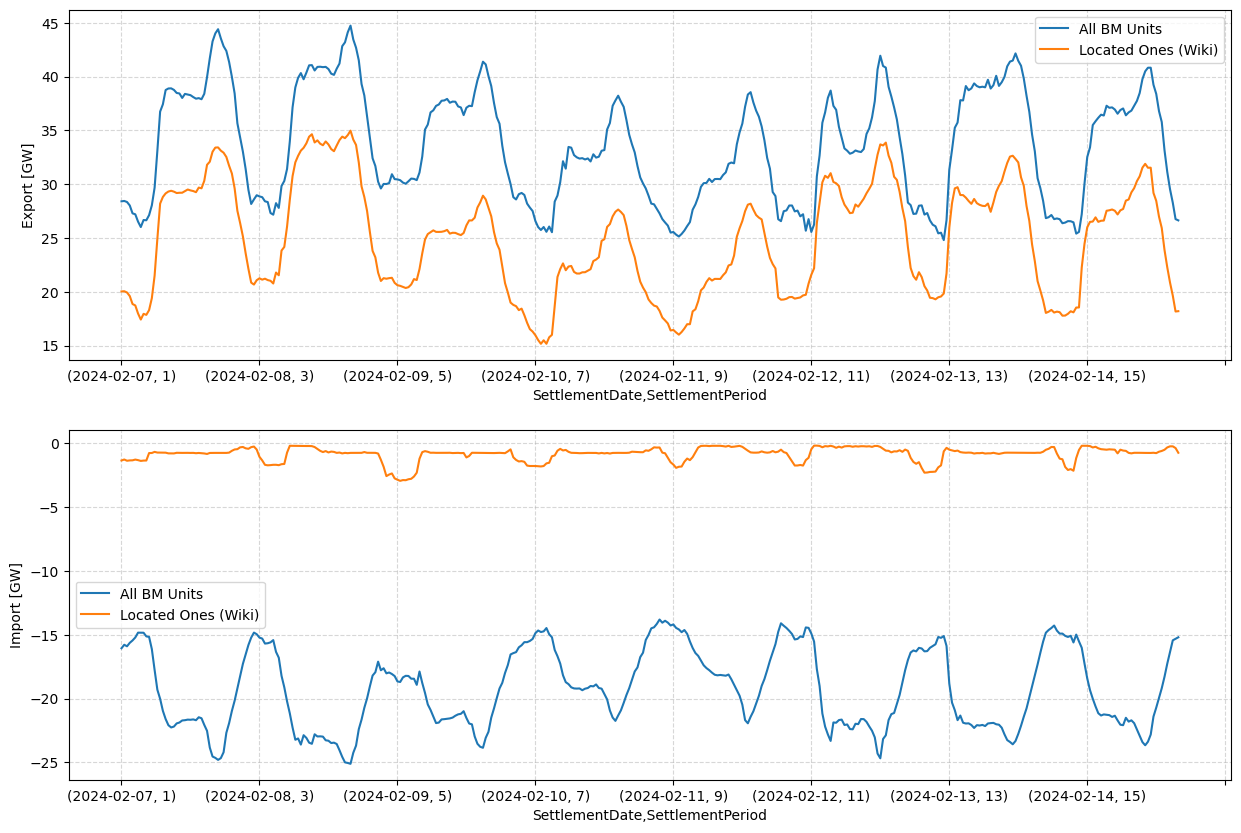

In [133]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

found_bm = bm.loc[idx[:,:,found_idx], :]

split = lambda df: (df.loc[df["LevelTo"] >= 0, "LevelTo"], df.loc[df["LevelTo"] < 0, "LevelTo"])

pos, neg = split(bm)
found_pos, found_neg = split(found_bm)

pos.groupby(level=[0,1]).sum().mul(1e-3).plot(label="All BM Units", ax=axs[0])
neg.groupby(level=[0,1]).sum().mul(1e-3).plot(label="All BM Units", ax=axs[1])
found_pos.groupby(level=[0,1]).sum().mul(1e-3).plot(label="Located Ones (Wiki)", ax=axs[0])
found_neg.groupby(level=[0,1]).sum().mul(1e-3).plot(label="Located Ones (Wiki)", ax=axs[1])

for ax in axs:
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
axs[0].set_ylabel("Export [GW]")
axs[1].set_ylabel("Import [GW]")
plt.show()

In [84]:
wiki["bmrs_id"].value_counts()
wiki.query("bmrs_id == 'CRYRW-3'")

,lat,lon,bmrs_id,repd_id,capacity,item,itemlabel,type
396,55.9,-2.55,CRYRW-3,3440,200.5,http://www.wikidata.org/entity/Q5191333,Q5191333,Q50687555
519,55.9,-2.55,CRYRW-3,3536,200.5,http://www.wikidata.org/entity/Q5191333,Q5191333,Q50687555
528,55.9,-2.55,CRYRW-3,4215,200.5,http://www.wikidata.org/entity/Q5191333,Q5191333,Q50687555
539,55.9,-2.55,CRYRW-3,3114,200.5,http://www.wikidata.org/entity/Q5191333,Q5191333,Q50687555
578,55.9,-2.55,CRYRW-3,4631,200.5,http://www.wikidata.org/entity/Q5191333,Q5191333,Q50687555


In [65]:
print(wiki.loc[0, "bmrs_id"])
print(type(wiki.loc[0, "bmrs_id"]))

print(unit)
print(type(unit))

GAOFO-1
<class 'str'>
TYLNB-1
<class 'str'>
